In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/CS 495 DataScience Capstone Project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CS 495 DataScience Capstone Project


# Anime Dataset Cleaning & EDA Notebook

This notebook performs comprehensive data cleaning, preprocessing, feature engineering, and exploratory analysis for anime story generation.

**Goal:** Prepare a clean dataset of anime prompts and synopses for training text generation models (LSTM, GRU, RNN, T5, GPT-2).

- **Dataset:** 'top_anime_dataset_v2.csv'

- **Output:** 'top_anime_cleaned_dataset.csv'

# I. Import Libraries

In [ ]:
# Import libraries
import os, pickle, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from collections import Counter

# II. Load  Dataset

In [ ]:
df = pd.read_csv('top_anime_dataset_v2.csv')
print("Initial Shape:", df.shape)
df.head()

Initial Shape: (15000, 24)


,anime_id,anime_url,image_url,name,english_name,japanese_names,score,genres,themes,demographics,synopsis,type,episodes,premiered,producers,studios,source,duration,rating,rank,popularity,favorites,scored_by,members
0,52991,https://myanimelist.net/anime/52991/Sousou_no_...,https://cdn.myanimelist.net/images/anime/1015/...,Sousou no Frieren,Frieren: Beyond Journey's End,葬送のフリーレン,9.31,"Adventure, Drama, Fantasy",NaN,Shounen,During their decade-long quest to defeat the D...,TV,28.0,fall 2023,"Aniplex, Dentsu, Shogakukan-Shueisha Productio...",Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,1.0,160,63387,605478,1038347
1,5114,https://myanimelist.net/anime/5114/Fullmetal_A...,https://cdn.myanimelist.net/images/anime/1208/...,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,9.10,"Action, Adventure, Drama, Fantasy",Military,Shounen,After a horrific alchemy experiment goes wrong...,TV,64.0,spring 2009,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",Bones,Manga,24 min per ep,R - 17+ (violence & profanity),2.0,3,232007,2196965,3484360
2,9253,https://myanimelist.net/anime/9253/Steins_Gate,https://cdn.myanimelist.net/images/anime/1935/...,Steins;Gate,Steins;Gate,STEINS;GATE,9.07,"Drama, Sci-Fi, Suspense","Psychological, Time Travel",NaN,Eccentric scientist Rintarou Okabe has a never...,TV,24.0,spring 2011,"Frontier Works, Media Factory, Kadokawa Shoten...",White Fox,Visual novel,24 min per ep,PG-13 - Teens 13 or older,3.0,14,194580,1450481,2669303
3,60022,https://myanimelist.net/anime/60022/One_Piece_...,https://cdn.myanimelist.net/images/anime/1455/...,One Piece Fan Letter,NaN,ONE PIECE FAN LETTER,9.06,"Action, Adventure, Fantasy",NaN,Shounen,Although the golden age of piracy is about to ...,TV Special,1.0,NaN,NaN,Toei Animation,Light novel,24 min,PG-13 - Teens 13 or older,4.0,2334,1976,69555,92128
4,38524,https://myanimelist.net/anime/38524/Shingeki_n...,https://cdn.myanimelist.net/images/anime/1517/...,Shingeki no Kyojin Season 3 Part 2,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,9.05,"Action, Drama, Suspense","Gore, Military, Survival",Shounen,Seeking to restore humanity's diminishing hope...,TV,10.0,spring 2019,"Production I.G, Dentsu, Mainichi Broadcasting ...",Wit Studio,Manga,23 min per ep,R - 17+ (violence & profanity),5.0,21,60535,1671960,2409440


# III. Check Missing Values

In [ ]:
missing = df.isnull().sum()
print("Missing Values:\n", missing[missing > 0])

Missing Values:
 english_name       6642
japanese_names       46
genres             1601
themes             5077
demographics      10592
synopsis            468
type                  1
episodes            112
premiered         10316
producers          5429
studios            2379
rating               68
rank               3080
dtype: int64


# IV. Flag Inappropriate Tags

In [ ]:
bad_keywords = ['hentain', 'ecchi', 'yaoi', 'yuri']

for col in ['genres', 'themes', 'demographics']:
  count = df[col].fillna('').astype(str).str.contains('|'.join(bad_keywords), case = False).sum()
  print(f"{count} rows contains inappropriate words in '{col}'")

rx_mask = df['rating'].fillna('').str.contains('rx - hentai', case = False)
print(f"{rx_mask.sum()} rows have 'Rx - Hentai' rating")

695 rows contains inappropriate words in 'genres'
0 rows contains inappropriate words in 'themes'
0 rows contains inappropriate words in 'demographics'
1205 rows have 'Rx - Hentai' rating


# V. Analyze Patterns in Synopsis

In [ ]:
df['synopsis_lower'] = df['synopsis'].str.lower().fillna('')

patterns = {
    'mal_rewrite': r'mal_rewrite',
    'source': r'source:',
    'edited': r'edited',
    'gkids': r'gkids',
    'http': r'http[s]?://'
}

for label, pattern in patterns.items():
  count = df['synopsis_lower'].str.contains(pattern, regex = True).sum()
  print(f"{label}: {count} matches")

mal_rewrite: 0 matches
source: 4827 matches
edited: 178 matches
gkids: 4 matches
http: 1 matches


# VI. Convert Tags to Lists

In [ ]:
def clean_tag_column(col):
  return df[col].fillna('').apply(lambda x: [tag.strip() for tag in x.split(',') if tag.strip()])

for col in ['genres', 'themes', 'demographics']:
  df[col] = clean_tag_column(col)

# VII. Review and Filter by Type

In [ ]:
print("Unique 'type' values:", df['type'].unique())
print("Counts:\n", df['type'].value_counts(dropna = False))

Unique 'type' values: ['TV' 'TV Special' 'Movie' 'OVA' 'Music' 'ONA' 'Special' 'PV' 'CM' nan]
Counts:
 type
TV            4716
OVA           2777
Movie         2090
ONA           1788
Music         1489
Special       1296
TV Special     506
CM             207
PV             130
NaN              1
Name: count, dtype: int64


# VIII. Clean Synopsis Text

In [ ]:
def clean_synopsis(text):
    if pd.isnull(text):
        return ""
    text = re.sub(r'\[.*?mal rewrite.*?\]', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\(source:.*?\)', '', text, flags=re.IGNORECASE)
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'edited', '', text, flags=re.IGNORECASE)
    text = re.sub(r'gkids', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['synopsis'] = df['synopsis'].fillna('').astype(str).apply(clean_synopsis)

# IX. Drop Bad Rows

In [ ]:
for col in ['genres', 'themes', 'demographics']:
  df = df[~df[col].astype(str).str.contains('|'.join(bad_keywords), case = False)]

df = df[~df['rating'].fillna('').str.contains('rx - hentai', case = False)]
df = df[~df['type'].isin(['Music', 'CM', 'PV'])]
df = df[df['synopsis'].str.len() > 30]
df.drop(columns = ['synopsis_lower'], inplace = True, errors = 'ignore')
df['english_name'] = df['english_name'].fillna(df['name'])
df.reset_index(drop = True, inplace = True)
print("Shape after all cleaning:", df.shape)

Shape after all cleaning: (10837, 24)


# X. Generate Prompt Context

In [ ]:
df['prompt_context'] = df.apply(
    lambda row: ' | '.join(filter(None, [
            f"Genre: {', '.join(row['genres'])}" if isinstance(row['genres'], list) else '',
            f"Theme: {', '.join(row['themes'])}" if isinstance(row['themes'], list) else '',
            f"Demographic: {', '.join(row['demographics'])}" if isinstance(row['demographics'], list) else ''
        ])), axis = 1
)

# XI. Check Duplicates

In [ ]:
duplicate_mask = df.duplicated(subset = ['prompt_context', 'synopsis'], keep = False)
print(f"Duplicate prompt-synopsis pairs: {duplicate_mask.sum()}")
df[duplicate_mask][['prompt_context', 'synopsis']].head()

Duplicate prompt-synopsis pairs: 150


,prompt_context,synopsis
30,"Genre: Action, Drama, Suspense | Theme: Gore, ...",A compilation movie for Shingeki no Kyojin: Th...
31,"Genre: Action, Drama, Suspense | Theme: Gore, ...",A compilation movie for Shingeki no Kyojin: Th...
245,"Genre: Drama | Theme: Music, Performing Arts, ...",Following their success in the qualifying roun...
347,"Genre: Action, Adventure, Fantasy | Theme: | ...","Two years after the Summit War, Monkey D. Luff..."
348,"Genre: Action, Adventure, Fantasy | Theme: | ...","Two years after the Summit War, Monkey D. Luff..."


# XII. Feature Engineering

In [ ]:
df['genre_count'] = df['genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df['theme_count'] = df['themes'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df['has_demographic'] = df['demographics'].apply(lambda x: len(x) > 0 if isinstance(x, list) else False)
df['synopsis_length'] = df['synopsis'].fillna('').str.len()
df['is_popular'] = df['members'] > df['members'].median()
df['log_members'] = np.log1p(df['members'].fillna(0))
df['log_favorites'] = np.log1p(df['favorites'].fillna(0))

# XIII. Outlier Removal

In [ ]:
members_cutoff = df['members'].quantile(0.99)
synopsis_cutoff = df['synopsis_length'].quantile(0.99)

print(f"Members 99% cutoff: {members_cutoff}")
print(f"Synopsis length 99% cutoff: {synopsis_cutoff}")

df = df[df['members'] <= members_cutoff]
df = df[df['synopsis_length'] <= synopsis_cutoff]

print("Shape after outlier removal:", df.shape)

Members 99% cutoff: 1260152.1199999994
Synopsis length 99% cutoff: 1409.6399999999994
Shape after outlier removal: (10626, 32)


# XIV. Check Skewness After Log Transform

In [ ]:
print("Skewness after log transform:")
print(df[['log_members', 'log_favorites', 'synopsis_length']].skew())

Skewness after log transform:
log_members        0.222627
log_favorites      0.586337
synopsis_length    0.425518
dtype: float64


# XV. EDA: Histograms for Key Features

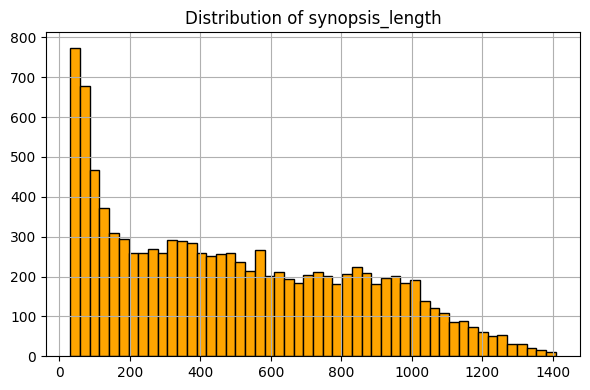

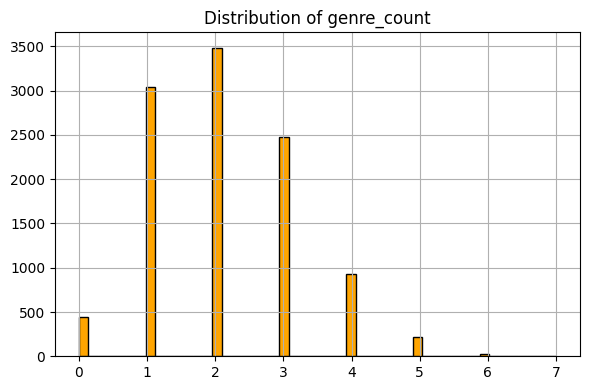

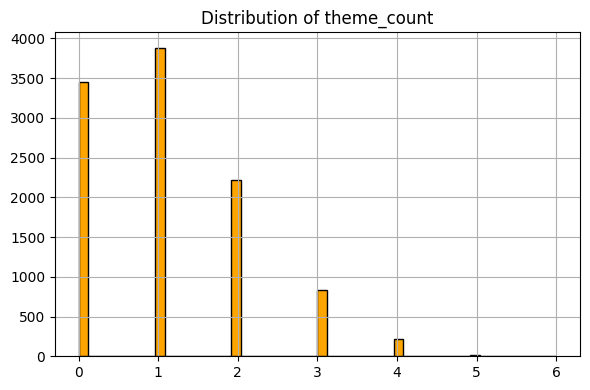

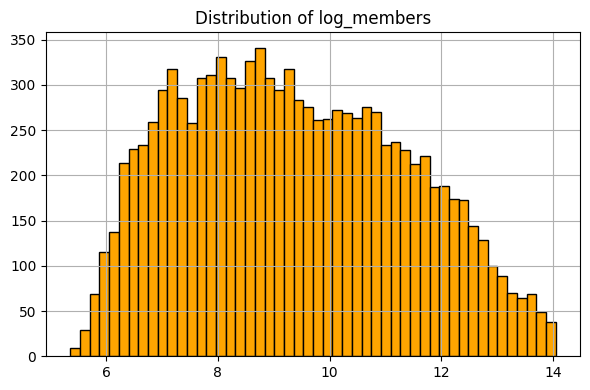

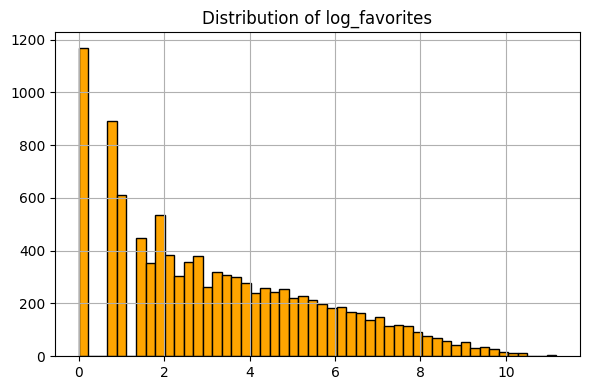

In [ ]:
cols_to_plot = ['synopsis_length', 'genre_count', 'theme_count', 'log_members', 'log_favorites']

for col in cols_to_plot:
  plt.figure(figsize = (6, 4))
  df[col].hist(bins = 50, color = 'orange', edgecolor = 'black')
  plt.title(f'Distribution of {col}')
  plt.grid(True)
  plt.tight_layout()
  plt.show()

# XVI. Tag Frequency Visualizations (Genres, Themes, Demographics)

## 1. Flatten and Plot Top 10 Genres & Themes

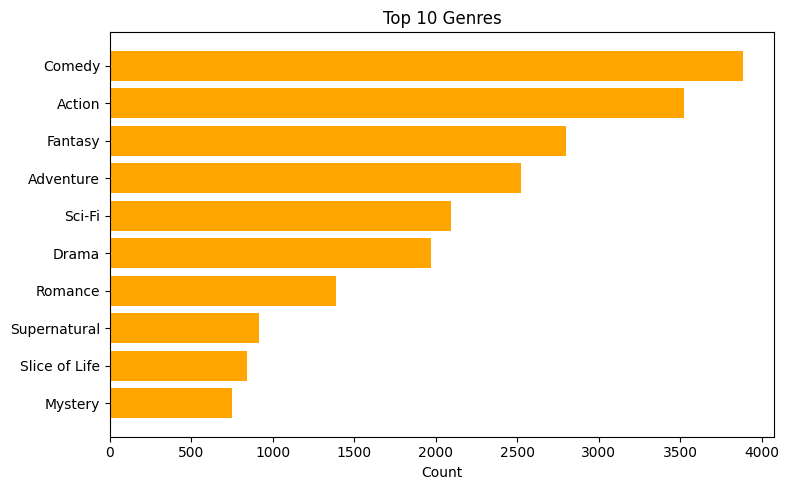

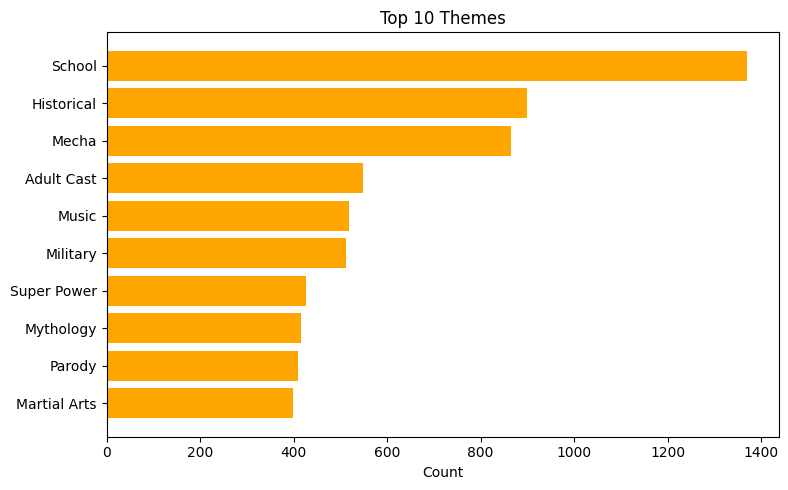

In [ ]:
from collections import Counter

# Flatten lists
all_genres = [genre for sublist in df['genres'] if isinstance(sublist, list) for genre in sublist]
all_themes = [theme for sublist in df['themes'] if isinstance(sublist, list) for theme in sublist]

# Helper function to plot top tags
def plot_top_tags(tag_list, title):
  counts = Counter(tag_list).most_common(10)
  tags, values = zip(*counts)

  plt.figure(figsize = (8, 5))
  plt.barh(tags[::-1], values[::-1], color = 'orange')
  plt.title(f"Top 10 {title}")
  plt.xlabel("Count")
  plt.tight_layout()
  plt.show()

# Plot
plot_top_tags(all_genres, "Genres")
plot_top_tags(all_themes, "Themes")

## 2. Demographic Pie Chart

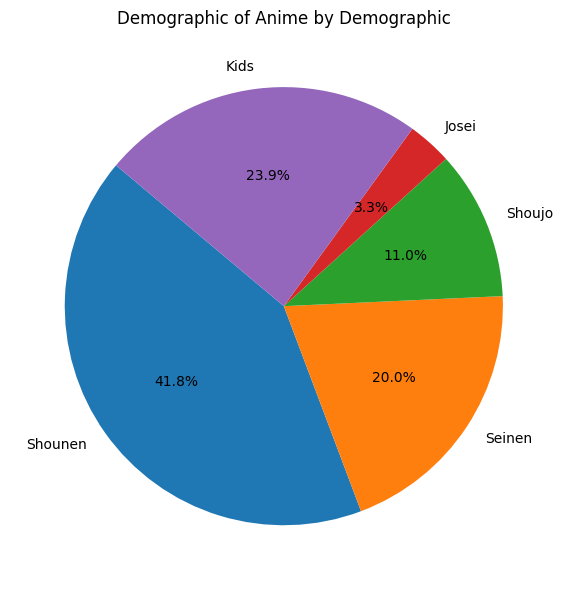

In [ ]:
all_demos = [demo for sublist in df['demographics'] if isinstance(sublist, list) for demo in sublist]
demo_counts = Counter(all_demos)

plt.figure(figsize = (6, 6))
plt.pie(demo_counts.values(), labels = demo_counts.keys(), autopct = '%1.1f%%', startangle = 140)
plt.title("Demographic of Anime by Demographic")
plt.tight_layout()
plt.show()

## 3. BoxPlot: Synopsis Length by Demographic

<ipython-input-96-5aec767df838>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_box, x = 'demographics', y = 'synopsis_length', palette = 'pastel')


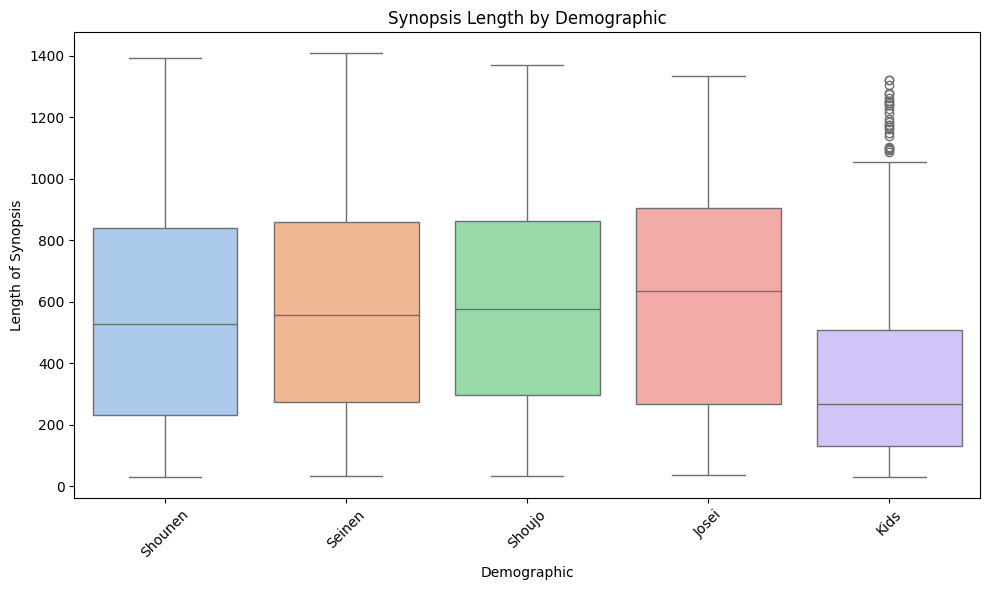

In [ ]:
df_box = df[df['demographics'].apply(lambda x: isinstance(x, list) and len(x) >0)].explode('demographics')

plt.figure(figsize = (10, 6))
sns.boxplot(data = df_box, x = 'demographics', y = 'synopsis_length', palette = 'pastel')
plt.title("Synopsis Length by Demographic")
plt.ylabel("Length of Synopsis")
plt.xlabel("Demographic")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

# XVII. Correlation Heatmap

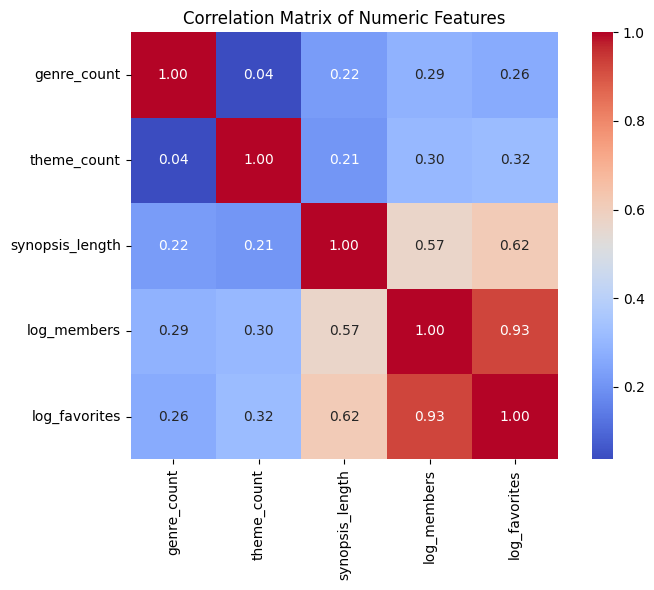

In [ ]:
# Select numerical features for correlation
numerical_cols = ['genre_count', 'theme_count', 'synopsis_length', 'log_members', 'log_favorites']

plt.figure(figsize = (8, 6))
sns.heatmap(df[numerical_cols].corr(), annot = True, cmap = 'coolwarm', fmt = '.2f', square = True)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

# XVIII. PCA Projection (2D)

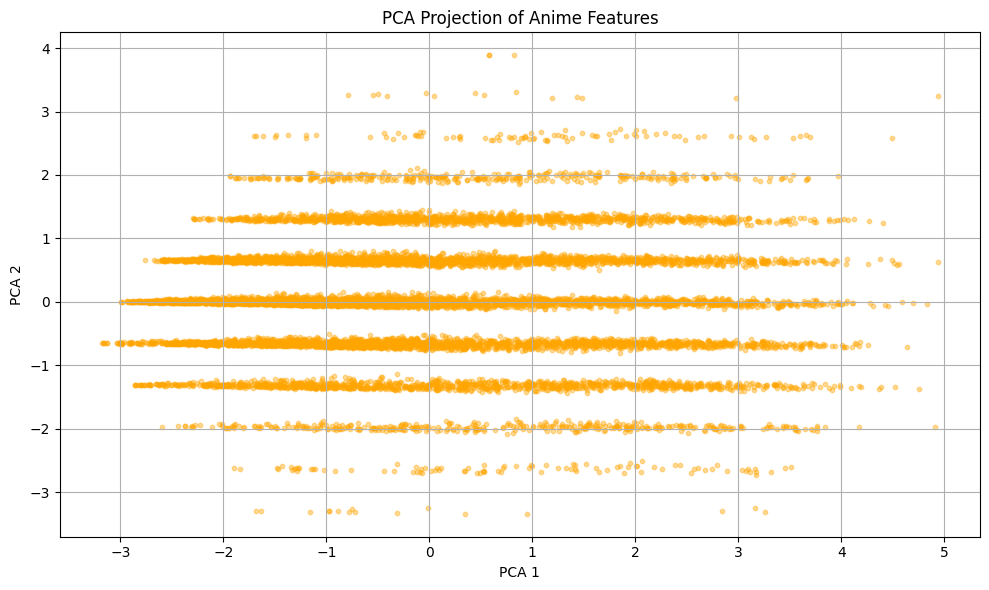

In [ ]:
# Standard Features
X = df[numerical_cols]
X_scaled = StandardScaler().fit_transform(X)

# Apply PCA
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)

# Plot the 2D projection
plt.figure(figsize = (10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s = 10, alpha = 0.4, color = 'orange')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA Projection of Anime Features")
plt.grid(True)
plt.tight_layout()
plt.show()

# XIX. Final Text Cleaning for Modeling

In [ ]:
def clean_text(text):
  text = str(text).lower().strip()
  text = re.sub(r"[^a-zA-Z0-9.,:;!?|'\[\] ]+", "", text)
  return text

df["synopsis"] = df["synopsis"].apply(clean_text)

if "prompt_context" in df.columns:
  df["prompt_context"] = df["prompt_context"].apply(clean_text)

# XX. Save Cleaned Dataset

In [ ]:
df.to_csv("top_anime_cleaned_dataset.cssv", index = False)
print("Saved cleaned dataset as: top_anime_cleaned_dataset.csv")

Saved cleaned dataset as: top_anime_cleaned_dataset.csv
